In [1]:
import pymongo
import pandas as pd
import numpy as np
from sklearn import datasets
import pickle
import time
import pymongo
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
import random
from pymongo import MongoClient
import pandas as pd
import os

Using TensorFlow backend.


In [2]:
def load_saved_model_from_db(model_name, client, db, dbconnection):
    json_data = {}
    
    #saving model to mongoDB
    # creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongodb
    mydb = myclient[db]
    
    #creating collection
    mycon = mydb[dbconnection]
    data = mycon.find({'name': model_name})
    
    
    for i in data:
        json_data = i
    #fetching model from db
    pickled_model = json_data[model_name]
    
    return pickle.loads(pickled_model)

In [3]:
details = {
        'inserted_id':"ObjectId('5eb3e0954668994dc15066e2')",
        'model_name':"CNN",
        'created_time':1588846741.541345 }

In [4]:
model  = load_saved_model_from_db(model_name = details['model_name'], client = 'mongodb://localhost:27017/', 
                         db = 'Cat_dog_classifier', dbconnection = 'Model_Accuracy_95.0%')

In [5]:
import pymongo

client=pymongo.MongoClient('mongodb://127.0.0.1:27017/')

db=client['Cat_dog_classifier']
Model_Accuracy_95_prediction = db.Model_Accuracy_95_prediction

In [6]:
def importing_data():
    train = []
    for record in Model_Accuracy_95_prediction.find({'Prediction':{'$gt':99.0}}):
        train.append(record)
    return train

In [7]:
df = importing_data()

In [8]:
df = pd.DataFrame(df)

In [9]:
df

,_id,filename,category,Dog,Cat,Prediction
0,5eb3f7ec7961379964593546,11835.jpg,dog,0.0,1.000000e+02,100.0
1,5eb3f7ec7961379964593547,4737.jpg,dog,0.0,1.000000e+02,100.0
2,5eb3f7ec7961379964593548,3323.jpg,dog,0.0,1.000000e+02,100.0
3,5eb3f7ec7961379964593549,4758.jpg,cat,100.0,0.000000e+00,100.0
4,5eb3f7ec796137996459354a,5678.jpg,cat,100.0,0.000000e+00,100.0
...,...,...,...,...,...,...
12442,5eb3f7ec7961379964596614,2338.jpg,cat,100.0,0.000000e+00,100.0
12443,5eb3f7ec7961379964596615,6422.jpg,dog,0.0,1.000000e+02,100.0
12444,5eb3f7ec7961379964596616,3040.jpg,cat,100.0,0.000000e+00,100.0
12445,5eb3f7ec7961379964596617,10816.jpg,cat,100.0,0.000000e+00,100.0


In [10]:
df = df.drop(['_id','Dog','Cat','Prediction'], axis = 1) 

In [11]:
df['category'].value_counts()

cat    6454
dog    5993
Name: category, dtype: int64

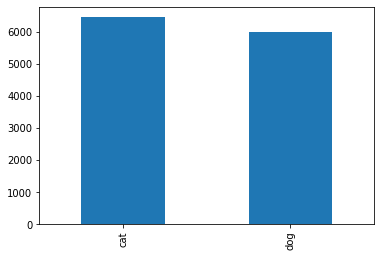

In [12]:
df['category'].value_counts().plot.bar()

In [13]:
def save():
     if df["category"].value_counts()[0] != df["category"].value_counts()[1]:
        print("yes")
        if df["category"].value_counts()[0] >= df["category"].value_counts()[1]: # cat [5172] >= Dog [4804]
            k = df["category"].value_counts()[0] - df["category"].value_counts()[1] # Dog [5172] - cat [4804]
            cat = df.loc[df['category'] == "cat"] # creating Dataframe that contains only cat data
            dog = df.loc[df['category'] == "dog"] # creating Dataframe that contains only Dog data
            example_df = cat.sample(n=df["category"].value_counts()[1]).reset_index(drop=True) # Droping 384 value from Cat column
            t = pd.concat([example_df,dog],axis =0) #concating both DataFrame
            return t
            
        elif df["category"].value_counts()[1] >= df["category"].value_counts()[0]: # 4804 >= 5172
            k = df["category"].value_counts()[1] - df["category"].value_counts()[0] # same as above 
            cat = df.loc[df['category'] == "cat"]
            dog = df.loc[df['category'] == "dog"]
            example_df = dog.sample(n=df["category"].value_counts()[0]).reset_index(drop=True)
            t1 = pd.concat([example_df,cat],axis =0)
            return t1
            
            

In [14]:
df = save()

yes


In [15]:
df

,filename,category
0,6613.jpg,cat
1,1757.jpg,cat
2,5865.jpg,cat
3,4382.jpg,cat
4,10033.jpg,cat
...,...,...
12431,876.jpg,dog
12437,2923.jpg,dog
12438,10329.jpg,dog
12441,6665.jpg,dog


In [16]:
df['category'].value_counts()

cat    5993
dog    5993
Name: category, dtype: int64

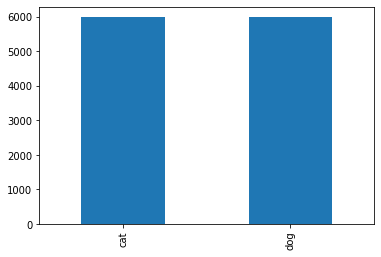

In [17]:
df['category'].value_counts().plot.bar()

In [18]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)


In [19]:
train_df['category'].value_counts()

dog    4814
cat    4774
Name: category, dtype: int64

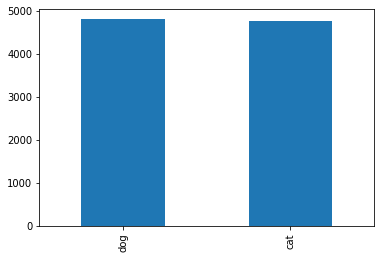

In [20]:
train_df['category'].value_counts().plot.bar()

In [21]:
validate_df['category'].value_counts()

cat    1219
dog    1179
Name: category, dtype: int64

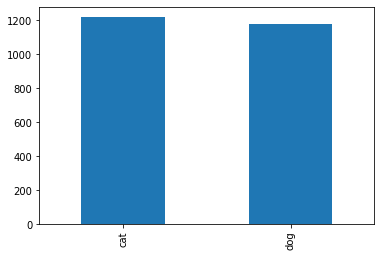

In [22]:
validate_df['category'].value_counts().plot.bar()

In [23]:
total_train = train_df.shape[0] # 20000
total_validate = validate_df.shape[0] # 500
batch_size=15

In [24]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=[IMAGE_WIDTH, IMAGE_HEIGHT]
IMAGE_CHANNELS=3

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "test1/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 9588 validated image filenames belonging to 2 classes.


In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "test1/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2398 validated image filenames belonging to 2 classes.


In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [29]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [30]:
epochs=2


history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/2
639/639 [==============================] - 305s 477ms/step - loss: 2.3930 - accuracy: 0.9498 - val_loss: 0.0000e+00 - val_accuracy: 0.9887
Epoch 2/2


/home/nitin/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


639/639 [==============================] - 308s 482ms/step - loss: 2.1895 - accuracy: 0.9501 - val_loss: 0.0000e+00 - val_accuracy: 0.9853


In [34]:
Accuracy = history.history['accuracy']
Accuracy =  Accuracy.pop()
Accuracy = Accuracy*100
Accuracy  = round(Accuracy)
Accuracy = str(Accuracy)
Accuracy = "Model_Accuracy_" + Accuracy + "%" 
Accuracy

'Model_Accuracy_95.0%'

In [32]:
def save_model_to_db(model, client, db, dbconnection, model_name):
    import pickle
    import time
    import pymongo
    #pickling the model
    pickled_model = pickle.dumps(model)
    
    #saving model to mongoDB
    # creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongodb
    mydb = myclient[db]
    
    #creating collection
    mycon = mydb[dbconnection]
    info = mycon.insert_one({model_name: pickled_model, 'name': model_name, 'created_time':time.time()})
    print(info.inserted_id, ' saved with this id successfully!')
    
    details = {
        'inserted_id':info.inserted_id,
        'model_name':model_name,
        'created_time':time.time()
    }
    print(details)
    return details

In [33]:
details = save_model_to_db(model = model, client ='mongodb://localhost:27017/', db = 'Cat_dog_classifier', 
                 dbconnection = Accuracy, model_name = "CNN")

5eb4750a8d12210df02127c0  saved with this id successfully!
{'inserted_id': ObjectId('5eb4750a8d12210df02127c0'), 'model_name': 'CNN', 'created_time': 1588884747.028385}
